<a href="https://colab.research.google.com/github/huangch/hplot_tutorial/blob/main/hplot_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## H-Plot: An Algorithm for Heterogeneity Studies - Overall Introduction

H-Plot is an algorithm designed to generate spatial insights for heterogeneity studies, particularly in the context of analyzing cell distributions and their relationships within a defined area, such as a tissue sample. The algorithm leverages graph-based spatial analysis techniques to understand the organization and interactions of different cell populations, with a focus on identifying and characterizing regions like tumor areas and their borders.

The core idea of H-Plot, as implemented in this notebook, involves several key stages:

1.  **Data Representation:** It starts by taking cell data, typically including cell locations and their predicted types or characteristics (simulated in Step 1).
2.  **Spatial Graph Construction:** It builds a spatial network or graph connecting neighboring cells using techniques like Delaunay triangulation (Step 2). This creates a representation of the spatial relationships between cells. Filtering edges based on distance helps to focus on potentially interacting cells.
3.  **Cell Type Identification:** Specific cell populations of interest, such as tumor cells and immune cells, are identified based on their characteristics (Step 3).
4.  **Neighborhood Analysis:** It performs k-hop neighbor analysis (Step 4) to understand the local spatial context of each cell within the constructed graph, identifying all cells reachable within a specified number of connections.
5.  **Region Identification:** Using the neighborhood information and cell type identification, it identifies spatially distinct regions, such as tumor regions, based on criteria like cell density and the proportion of specific cell types (Step 5).
6.  **Boundary Identification and Distance Calculation:** It identifies the boundaries of these regions (e.g., tumor border cells in Step 6) and calculates the distance of every cell to this boundary (Step 7). A signed distance is used to indicate whether a cell is inside or outside the region.
7.  **Visualization and Analysis:** Finally, it visualizes the spatial data, often highlighting cell types, regions, boundaries, and the calculated signed distances (Step 8). Further analysis, such as examining cell type ratios as a function of distance to the border (Step 9), can provide quantitative insights into spatial heterogeneity.

In essence, H-Plot provides a systematic approach to analyze spatial heterogeneity by transforming cell location and type data into a graph, identifying specific regions and boundaries, and quantifying the spatial relationship of cells to these features. This allows researchers to gain insights into the spatial organization of cells and how different cell populations are distributed relative to areas of interest like tumor borders, which can be crucial for understanding biological processes and disease characteristics.

In [1]:
%pip install -U "git+https://github.com/huangch/hplot.git@main"

  Cloning https://github.com/huangch/hplot.git (to revision main) to /tmp/pip-req-build-6gjd6r9y
  Running command git clone --filter=blob:none --quiet https://github.com/huangch/hplot.git /tmp/pip-req-build-6gjd6r9y
  Resolved https://github.com/huangch/hplot.git to commit b893964ad06b30c049ccdca6b8998b4dc9e97002
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import Delaunay
from collections import deque
import matplotlib.pyplot as plt # Added matplotlib import
from matplotlib.colors import TwoSlopeNorm # Import TwoSlopeNorm for potentially centering colormap
from hplot.core import HPlot

In [3]:
def simulate_model_outputs(num_cells, image_width, image_height, patch_width=61, patch_height=61, cell_type_list=['epithelial','fibroblast','other','lymphocytes','tumor','macrophages'], num_clusters=3, cluster_deviation=50):
  """
  Simulates a pandas DataFrame with model output data, including tumor clusters.

  Args:
    num_cells: The total number of cells to simulate.
    image_width: The width of the image in pixels.
    image_height: The height of the image in pixels.
    patch_width: The fixed width of each cell patch (default is 61).
    patch_height: The fixed height of each patch (default is 61).
    cell_type_list: A list of cell type names (default includes 'tumor').
    num_clusters: The number of tumor clusters to simulate (default is 3).
    cluster_deviation: The standard deviation for the Gaussian clusters, controlling their spread (default is 50).

  Returns:
    A pandas DataFrame simulating the model output data with columns for coordinates and cell type probabilities.
  """
  # Determine the number of tumor cells based on a random fraction
  tumor_fraction = np.random.uniform(0.1, 0.4)
  num_tumor_cells = int(num_cells * tumor_fraction)
  # Corrected the calculation of num_non_tumor_cells
  num_non_tumor_cells = num_cells - num_tumor_cells

  # Generate cluster centers (means) and covariance matrices for tumor cells using a Gaussian mixture model approach
  cluster_centers = []
  covariances = []
  for _ in range(num_clusters):
    # Randomly select cluster centers within image boundaries
    mean_x = np.random.randint(0, image_width - patch_width)
    mean_y = np.random.randint(0, image_height - patch_height)
    cluster_centers.append([mean_x, mean_y])
    # Create a diagonal covariance matrix with the specified deviation
    covariances.append(np.diag(np.full(2, cluster_deviation**2)))

  tumor_coords = []
  # Distribute tumor cells among the generated clusters
  cells_per_cluster = np.random.multinomial(num_tumor_cells, np.ones(num_clusters)/num_clusters)

  for i in range(num_clusters):
    num_cells_in_cluster = cells_per_cluster[i]
    mean = cluster_centers[i]
    cov = covariances[i]

    # Generate coordinates for the cells in the current cluster using a multivariate normal distribution
    coords = np.random.multivariate_normal(mean, cov, num_cells_in_cluster)

    # Ensure generated coordinates are within image boundaries
    coords[:, 0] = np.clip(coords[:, 0], 0, image_width - patch_width)
    coords[:, 1] = np.clip(coords[:, 1], 0, image_height - patch_height)

    tumor_coords.append(coords)

  # Combine coordinates from all tumor clusters
  tumor_coords = np.vstack(tumor_coords)

  # Generate random coordinates for non-tumor cells within image boundaries
  non_tumor_minx = np.random.randint(0, image_width - patch_width, num_non_tumor_cells)
  non_tumor_miny = np.random.randint(0, image_height - patch_height, num_non_tumor_cells)
  non_tumor_coords = np.vstack([non_tumor_minx, non_tumor_miny]).T

  # Combine tumor and non-tumor coordinates
  all_minx = np.concatenate([tumor_coords[:, 0], non_tumor_coords[:, 0]])
  all_miny = np.concatenate([tumor_coords[:, 1], non_tumor_coords[:, 1]])

  # Initialize a dictionary to hold the DataFrame data
  data = {}
  data['minx'] = all_minx
  data['miny'] = all_miny
  data['width'] = np.full(num_cells, patch_width)
  data['height'] = np.full(num_cells, patch_height)

  # Create a boolean array to easily identify tumor cells
  is_tumor_cell = np.concatenate([np.full(num_tumor_cells, True), np.full(num_non_tumor_cells, False)])

  # Simulate probabilities for each cell type
  num_cell_types = len(cell_type_list)
  probs = np.zeros((num_cells, num_cell_types))
  # Get the index of 'tumor' in the cell_type_list
  tumor_cell_index = cell_type_list.index('tumor')

  for i in range(num_cells):
      if is_tumor_cell[i]:
          # Assign a high probability to 'tumor' for tumor cells
          probs[i, tumor_cell_index] = np.random.uniform(0.8, 1.0)
          remaining_prob = 1.0 - probs[i, tumor_cell_index]
          # Distribute the remaining probability among other cell types
          other_cell_indices = [j for j in range(num_cell_types) if j != tumor_cell_index]
          if remaining_prob > 0 and len(other_cell_indices) > 0:
              random_distribution = np.random.rand(len(other_cell_indices))
              random_distribution = random_distribution / random_distribution.sum() # Normalize to sum to 1
              probs[i, other_cell_indices] = remaining_prob * random_distribution
      else:
          # Randomly assign probabilities for non-tumor cells, normalized to sum to 1
          probs[i, :] = np.random.rand(num_cell_types)
          probs[i, :] = probs[i, :] / probs[i, :].sum()

  # Add probability columns to the data dictionary
  for i, cell_type in enumerate(cell_type_list):
    data[f'prob_{cell_type}'] = probs[:, i]

  # Create the final DataFrame
  df = pd.DataFrame(data)
  return df

In [4]:
def delaunay_triangulation(model_output_df, max_edge_length):
    """
    Performs Delaunay triangulation on cell center points and filters edges by length.

    Args:
        model_output_df: DataFrame with 'minx', 'miny', 'width', 'height' columns.
        max_edge_length: Maximum length for edges to be included in the analysis.

    Returns:
        A tuple containing:
        - A DataFrame of edges with 'source', 'target', and 'length' columns representing point indices and edge length,
          filtered by max_edge_length.
        - The DataFrame with 'center_x' and 'center_y' columns added.
    """
    # Calculate cell center points if not already present
    if 'center_x' not in model_output_df.columns or 'center_y' not in model_output_df.columns:
        model_output_df['center_x'] = np.rint(model_output_df['minx'] + (model_output_df['width'] / 2)).astype(np.int32)
        model_output_df['center_y'] = np.rint(model_output_df['miny'] + (model_output_df['height'] / 2)).astype(np.int32)

    points = model_output_df[['center_x', 'center_y']].values

    # Perform Delaunay triangulation
    tri = Delaunay(points)

    # Get the edges of the triangulation
    # The edges are pairs of indices into the points array
    edges = set()
    for simplex in tri.simplices:
        edges.add(tuple(sorted((simplex[0], simplex[1]))))
        edges.add(tuple(sorted((simplex[0], simplex[2]))))
        edges.add(tuple(sorted((simplex[1], simplex[2]))))

    # Filter edges by length and store in a list of dictionaries
    filtered_edges_list = []
    for i, j in edges:
        point1 = points[i]
        point2 = points[j]
        distance = np.linalg.norm(point1 - point2)
        if distance < max_edge_length:
            filtered_edges_list.append({'source': i, 'target': j, 'length': distance})

    # Convert the list of dictionaries to a pandas DataFrame
    filtered_edges_df = pd.DataFrame(filtered_edges_list)

    return filtered_edges_df, model_output_df # Return both filtered edges DataFrame and the updated DataFrame

In [5]:
def create_adjacency_list(edges_df):
    """
    Creates an adjacency list from a DataFrame of edges.

    Args:
        edges_df: DataFrame with 'source' and 'target' columns representing edges.

    Returns:
        A dictionary representing the adjacency list.
    """
    adjacency_list = {}
    for index, row in edges_df.iterrows():
        # Convert source and target to integers explicitly
        source = int(row['source'])
        target = int(row['target'])

        if source not in adjacency_list:
            adjacency_list[source] = []
        if target not in adjacency_list:
            adjacency_list[target] = []

        adjacency_list[source].append(target)
        adjacency_list[target].append(source) # Assuming undirected graph

    return adjacency_list

In [6]:
def k_hop_neighbors(df, edges_df, k):
    """
    Finds k-hop neighbors for all cells in a DataFrame using a DataFrame of edges.

    Args:
        df: DataFrame with cell data.
        edges_df: DataFrame with 'source' and 'target' columns representing connections between cells.
        k: The number of hops.

    Returns:
        A list of lists, where each inner list contains the indices of all cells
        reachable from the corresponding cell within k hops.
    """

    # Create adjacency list from the edges DataFrame
    adjacency_list = create_adjacency_list(edges_df)

    def k_hop_search(start_node, k, adjacency_list):
        """
        Performs a k-hop search starting from a given node using BFS.

        Args:
            start_node: The index of the starting node.
            k: The number of hops.
            adjacency_list: The adjacency list representation of the graph.

        Returns:
            A set of reachable node indices within k hops (including the start node).
        """
        visited = set()
        queue = deque([(start_node, 0)])  # (node, distance)
        reachable_nodes = set()

        while queue:
            current_node, distance = queue.popleft() # Using popleft for BFS

            if current_node not in visited and distance <= k:
                visited.add(current_node)
                reachable_nodes.add(current_node)

                if distance < k and current_node in adjacency_list:
                    for neighbor in adjacency_list[current_node]:
                        if neighbor not in visited:
                            queue.append((neighbor, distance + 1))

        return sorted(list(reachable_nodes))

    # Apply k-hop search to all cells
    all_k_hop_neighbors = []
    for i in df.index:
        reachable_neighbors = k_hop_search(start_node=i, k=k, adjacency_list=adjacency_list)
        all_k_hop_neighbors.append(reachable_neighbors)

    return all_k_hop_neighbors

In [7]:
def identify_tumor_cells(model_output_df, tumor_cell_type, cell_type_list):
    """
    Identifies tumor cells in the DataFrame based on the highest probability.

    Args:
        model_output_df: DataFrame with probability columns for each cell type.
        cell_type_list: A list of cell type names.

    Returns:
        The DataFrame with a new boolean column 'is_tumor' indicating tumor cells.
    """
    prob_columns = [f'prob_{cell_type}' for cell_type in cell_type_list]
    model_output_df['is_tumor'] = model_output_df[prob_columns].idxmax(axis=1) == f'prob_{tumor_cell_type}'
    return model_output_df

In [8]:
def identify_immune_cells(model_output_df, immune_cell_type, cell_type_list):
    """
    Identifies immune cells in the DataFrame based on the highest probability.

    Args:
        model_output_df: DataFrame with probability columns for each cell type.
        cell_type_list: A list of cell type names.

    Returns:
        The DataFrame with a new boolean column 'is_immune' indicating immune cells.
    """
    prob_columns = [f'prob_{cell_type}' for cell_type in cell_type_list]
    model_output_df['is_immune'] = model_output_df[prob_columns].idxmax(axis=1) == f'prob_{immune_cell_type}'
    return model_output_df

In [9]:
def cell_function_enrichment_analysis(k_hop_neighbors_list, model_output_df, N, R):
    """
    Identifies cells whose k-hop neighborhood meets specified criteria for size and tumor cell ratio,
    and adds an 'is_tumor_region' column to the DataFrame.

    Args:
        k_hop_neighbors_list: A list of lists, where each inner list contains the indices
                              of k-hop neighbors for the corresponding cell.
        model_output_df: A pandas DataFrame containing cell information, including a boolean column
            'is_tumor' indicating tumor cells.
        N: The minimal number of neighbors required in the k-hop neighborhood.
        R: The minimal ratio of tumor cells required in the k-hop neighborhood.

    Returns:
        The input DataFrame with a new boolean column 'is_tumor_region' indicating cells
        that meet the enrichment criteria.
    """
    # Create a copy to avoid modifying the original DataFrame outside the function's scope
    df = model_output_df.copy()
    enriched_cells = []
    for i, neighbors in enumerate(k_hop_neighbors_list):
        if len(neighbors) >= N:
            # Get the subset of the DataFrame for the neighbors
            neighbor_df = df.iloc[neighbors]
            # Calculate the ratio of tumor cells in the neighborhood
            tumor_ratio = neighbor_df['is_tumor'].sum() / len(neighbors)
            if tumor_ratio >= R:
                enriched_cells.append(i)

    # Add the 'is_tumor_region' column to the DataFrame
    df['is_tumor_region'] = df.index.isin(enriched_cells)

    return df

In [10]:
def identify_tumor_border_cells(model_output_df, adjacency_list):
    """
    Identifies tumor border cells based on connections to non-tumor region cells.

    Args:
        model_output_df: DataFrame with 'is_tumor_region' column.
        adjacency_list: Adjacency list representing connections between cells.

    Returns:
        The DataFrame with a new boolean column 'is_tumor_border'.
    """
    model_output_df['is_tumor_border'] = False
    # Optimize by iterating through tumor region cells only
    tumor_region_indices = model_output_df[model_output_df['is_tumor_region']].index
    for index in tumor_region_indices:
        if index in adjacency_list:
            for neighbor_index in adjacency_list[index]:
                # Ensure neighbor exists in the DataFrame index and is not in a tumor region
                if neighbor_index in model_output_df.index and not model_output_df.loc[neighbor_index, 'is_tumor_region']:
                    model_output_df.loc[index, 'is_tumor_border'] = True
                    break # No need to check other neighbors if one non-tumor neighbor is found
    return model_output_df

In [11]:
def calculate_distance_to_border(model_output_df, adjacency_list):
    """
    Calculates the shortest distance from every cell to the nearest tumor border cell.

    Args:
        model_output_df: DataFrame with 'is_tumor_border' column.
        adjacency_list: Adjacency list representing connections between cells.

    Returns:
        The DataFrame with a new column 'distance_to_border'.
    """
    # Initialize distances to infinity for all cells
    distance_to_border = {index: float('inf') for index in model_output_df.index}
    queue = deque()

    # Start BFS from all tumor border cells
    border_cells = model_output_df[model_output_df['is_tumor_border']].index.tolist()
    for border_index in border_cells:
         # Ensure border cell exists in the graph keys before adding to queue
        if border_index in adjacency_list:
            distance_to_border[border_index] = 0
            queue.append(border_index)


    while queue:
        current_cell = queue.popleft()

        if current_cell in adjacency_list:
            for neighbor in adjacency_list[current_cell]:
                # Ensure neighbor exists in the DataFrame index and hasn't been visited
                if neighbor in model_output_df.index and distance_to_border[neighbor] == float('inf'):
                    distance_to_border[neighbor] = distance_to_border[current_cell] + 1
                    queue.append(neighbor)

    # Add the calculated distances to the DataFrame
    model_output_df['distance_to_border'] = model_output_df.index.map(distance_to_border)

    return model_output_df

In [12]:
def calculate_cumulative_avg_distance_immune_cell_ratio(df_with_distances, filtered_edges_df):
    """
    Calculates the immune cell ratio by cumulative average distance to the tumor border.

    Args:
        df_with_distances: DataFrame with 'signed_distance_to_border' and 'is_immune' columns.
        filtered_edges_df: DataFrame with 'source', 'target', and 'length' columns representing filtered edges.

    Returns:
        A pandas DataFrame with 'cumulative_avg_edge_length' and 'immune_ratio' columns,
        sorted by cumulative_avg_edge_length, ready for plotting.
    """
    # Group by signed_distance_to_border and calculate the ratio of immune cells
    # Handle potential empty groups or no immune cells at a distance
    # Exclude NaN distances from grouping
    immune_ratio_by_distance = df_with_distances.dropna(subset=['signed_distance_to_border']).groupby('signed_distance_to_border')['is_immune'].apply(lambda x: x.sum() / len(x) if len(x) > 0 else np.nan).dropna()

    # Step 1: Calculate average edge length between adjacent layers
    average_edge_length_between_layers = {}
    unique_distances = sorted(df_with_distances['signed_distance_to_border'].dropna().unique())

    for i in range(len(unique_distances) - 1):
        dist1 = unique_distances[i]
        dist2 = unique_distances[i+1]

        # Identify cells in the two adjacent layers
        cells_in_dist1 = df_with_distances[df_with_distances['signed_distance_to_border'] == dist1].index
        cells_in_dist2 = df_with_distances[df_with_distances['signed_distance_to_border'] == dist2].index

        # Find edges connecting cells in dist1 to cells in dist2
        connecting_edges = filtered_edges_df[
            ((filtered_edges_df['source'].isin(cells_in_dist1)) & (filtered_edges_df['target'].isin(cells_in_dist2))) |
            ((filtered_edges_df['source'].isin(cells_in_dist2)) & (filtered_edges_df['target'].isin(cells_in_dist1)))
        ]

        # Calculate the average length of these connecting edges
        if not connecting_edges.empty:
            average_length = connecting_edges['length'].mean()
            # Store the average length associated with the lower distance value of the pair
            # This makes the cumulative sum calculation more straightforward
            average_edge_length_between_layers[dist1] = average_length
        else:
            # Assign NaN if no edges connect these layers
            average_edge_length_between_layers[dist1] = np.nan

    # Step 2 & 3: Order average lengths by signed distance and calculate cumulative average edge length
    # Convert the dictionary to a pandas Series for easy sorting and cumulative sum
    avg_lengths_series = pd.Series(average_edge_length_between_layers)

    # Sort by the signed distance (index)
    avg_lengths_series = avg_lengths_series.sort_index()

    # A clearer way for cumulative sum with sign:
    cumulative_avg_lengths_dict = {0.0: 0.0} # Start at the border

    # Cumulative outwards (positive distances)
    current_dist = 0.0
    for signed_dist in sorted(unique_distances):
        if signed_dist > 0:
            prev_dist = unique_distances[unique_distances.index(signed_dist) - 1]
            if prev_dist in average_edge_length_between_layers: # avg length between prev_dist and signed_dist
                 current_dist += average_edge_length_between_layers[prev_dist]
                 cumulative_avg_lengths_dict[signed_dist] = current_dist
            elif signed_dist-1 in average_edge_length_between_layers: # Check if avg length from n-1 to n is available
                 current_dist += average_edge_length_between_layers[signed_dist-1]
                 cumulative_avg_lengths_dict[signed_dist] = current_dist
            else:
                cumulative_avg_lengths_dict[signed_dist] = np.nan # If no edge to prev layer, cumulative is NaN


    # Cumulative inwards (negative distances)
    current_dist = 0.0
    for signed_dist in sorted(unique_distances, reverse=True):
        if signed_dist < 0:
            next_dist = unique_distances[unique_distances.index(signed_dist) + 1]
            if signed_dist in average_edge_length_between_layers: # avg length between signed_dist and next_dist
                 current_dist -= average_edge_length_between_layers[signed_dist] # Subtract as we move inwards
                 cumulative_avg_lengths_dict[signed_dist] = current_dist
            else:
                cumulative_avg_lengths_dict[signed_dist] = np.nan # If no edge to next layer, cumulative is NaN


    # Convert the dictionary to a Series and align with signed distances in plot_df
    cumulative_avg_lengths_series = pd.Series(cumulative_avg_lengths_dict)

    # Step 4 & 5: Group immune cell ratio by signed distance and align with cumulative average edge lengths
    plot_df = pd.DataFrame({
        'signed_distance': immune_ratio_by_distance.index,
        'immune_ratio': immune_ratio_by_distance.values
    })

    # Map the cumulative average edge lengths to the signed_distance in plot_df
    plot_df['cumulative_avg_edge_length'] = plot_df['signed_distance'].map(cumulative_avg_lengths_series)

    # Drop rows where we couldn't calculate the cumulative average edge length
    plot_df = plot_df.dropna(subset=['cumulative_avg_edge_length'])

    # Sort by the new x-axis values for a clear line plot
    plot_df = plot_df.sort_values('cumulative_avg_edge_length')

    return plot_df

### Step 1: Simulate Data

This initial step simulates the biological data that the subsequent analysis pipeline will process. It generates a dataset of cell locations and their predicted cell type probabilities, mimicking the output of a computational model applied to biological images.

*   **Simulating Cell Locations:** The `simulate_model_outputs` function is used to create a DataFrame with `minx` and `miny` coordinates for each cell. It also includes `width` and `height` for potential visualization or further calculations.
*   **Simulating Cell Type Probabilities:** The function assigns probabilities for different cell types (like 'epithelial', 'tumor', 'lymphocytes', etc.) to each simulated cell. This allows for the identification of specific cell populations in later steps.
*   **Simulating Tumor Clusters:** The simulation specifically includes logic to generate cells in clusters, which can represent tumor regions in a biological sample.
*   **Output:** The result is a pandas DataFrame containing all this simulated information, ready for spatial analysis. The accompanying plot visualizes the generated cell locations.

This step provides the foundational data upon which the entire spatial analysis pipeline is built.

--- Simulating Data ---
Simulated DataFrame (first 5 rows):


,minx,miny,width,height,prob_epithelial,prob_fibroblast,prob_other,prob_lymphocytes,prob_tumor,prob_macrophages
0,1203.963221,600.756497,61,61,0.025935,0.010666,0.052516,0.035194,0.833802,0.041887
1,1173.255893,570.612375,61,61,0.030700,0.007159,0.056043,0.051074,0.847728,0.007297
2,1178.322404,543.938169,61,61,0.017346,0.023659,0.046936,0.034197,0.839359,0.038502
3,1255.250506,640.067661,61,61,0.020555,0.020690,0.027546,0.064762,0.803156,0.063292
4,1213.242165,606.902679,61,61,0.023954,0.003069,0.034819,0.042839,0.867435,0.027884


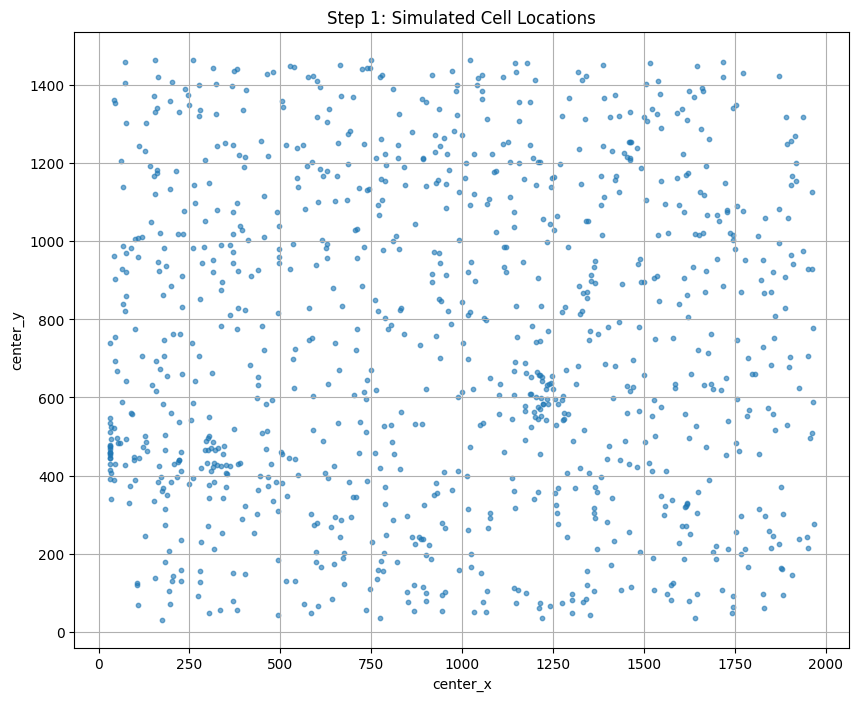

In [13]:
# --- Step 1: Simulate Data ---
num_cells = 1000
image_width = 2000
image_height = 1500
patch_width = 61
patch_height = 61
cell_type_list = ['epithelial','fibroblast','other','lymphocytes','tumor','macrophages']
num_clusters = 3
cluster_deviation = 50

print("--- Simulating Data ---")
simulated_df = simulate_model_outputs(num_cells, image_width, image_height, patch_width, patch_height, cell_type_list, num_clusters, cluster_deviation)
print("Simulated DataFrame (first 5 rows):")
display(simulated_df.head())

# Plot after data simulation
plt.figure(figsize=(10, 8))
plt.scatter(simulated_df['minx'] + simulated_df['width']/2, simulated_df['miny'] + simulated_df['height']/2, s=10, alpha=0.6)
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title('Step 1: Simulated Cell Locations')
plt.grid(True)
plt.show()

### Step 2: Delaunay Triangulation and Edge Filtering

This step takes the simulated cell location data from Step 1 and builds a spatial network of connections between the cells using **Delaunay triangulation**.

*   **Delaunay Triangulation:** This is a method that connects a set of points (the cell centers in this case) with triangles such that no point is inside the circumcircle of any triangle. This creates a mesh of connections between neighboring cells.
*   **Edge Filtering:** After the triangulation, the code filters the edges of these triangles. It keeps only those edges (connections) that are shorter than a specified `max_edge_length`. This is useful to remove connections between cells that are considered too far apart to be biologically relevant or interacting.
*   **Output:** The output of this step is a DataFrame containing the filtered edges (with source and target cell indices and the edge length) and the original DataFrame with the calculated center coordinates of each cell added.

This step is crucial for defining the spatial relationships and connectivity between cells, which is then used in subsequent graph-based analyses like finding k-hop neighbors and identifying tumor borders.


--- Performing Delaunay Triangulation and Filtering Edges (max_edge_length=100) ---
Number of Filtered Delaunay Edges: 2622
DataFrame with Center Coordinates (first 5 rows):


,minx,miny,width,height,prob_epithelial,prob_fibroblast,prob_other,prob_lymphocytes,prob_tumor,prob_macrophages,center_x,center_y
0,1203.963221,600.756497,61,61,0.025935,0.010666,0.052516,0.035194,0.833802,0.041887,1234,631
1,1173.255893,570.612375,61,61,0.030700,0.007159,0.056043,0.051074,0.847728,0.007297,1204,601
2,1178.322404,543.938169,61,61,0.017346,0.023659,0.046936,0.034197,0.839359,0.038502,1209,574
3,1255.250506,640.067661,61,61,0.020555,0.020690,0.027546,0.064762,0.803156,0.063292,1286,671
4,1213.242165,606.902679,61,61,0.023954,0.003069,0.034819,0.042839,0.867435,0.027884,1244,637


Filtered Edges DataFrame (first 5 rows):


,source,target,length
0,91,416,91.706052
1,331,477,54.147945
2,153,736,40.792156
3,677,742,92.086915
4,154,472,70.767224


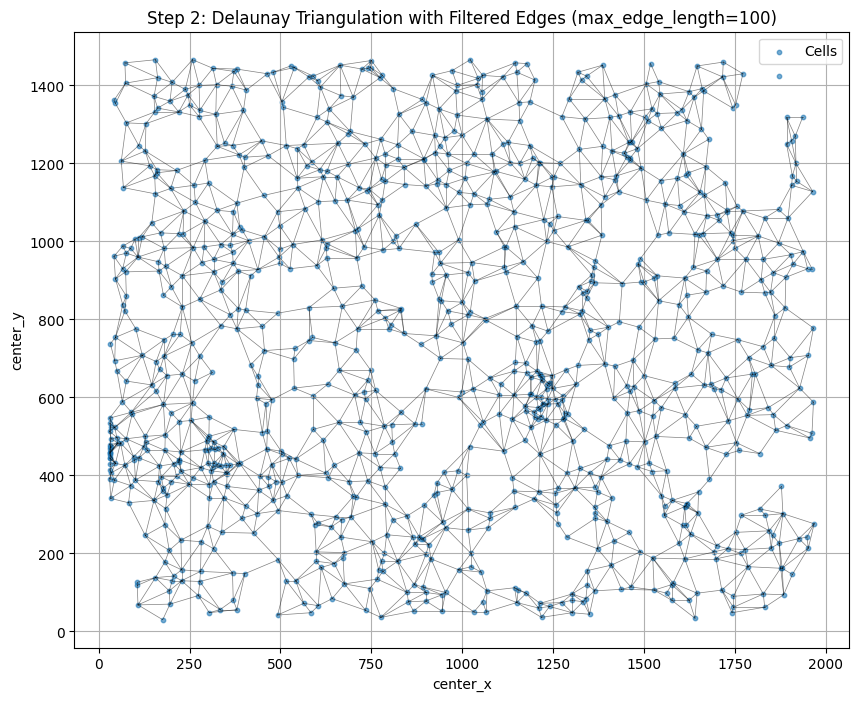

In [14]:
# --- Step 2: Delaunay Triangulation and Edge Filtering ---
max_edge_length = 100
print(f"\n--- Performing Delaunay Triangulation and Filtering Edges (max_edge_length={max_edge_length}) ---")
filtered_edges_df, df_with_centers = delaunay_triangulation(simulated_df.copy(), max_edge_length)
print(f"Number of Filtered Delaunay Edges: {len(filtered_edges_df)}")
print("DataFrame with Center Coordinates (first 5 rows):")
display(df_with_centers.head())
print("Filtered Edges DataFrame (first 5 rows):")
display(filtered_edges_df.head())

# Plot after Delaunay Triangulation and Edge Filtering
plt.figure(figsize=(10, 8))
points = df_with_centers[['center_x', 'center_y']].values
plt.scatter(points[:, 0], points[:, 1], s=10, alpha=0.6, label='Cells')
# Iterate through rows of the DataFrame to get source and target indices
for index, row in filtered_edges_df.iterrows():
    # Convert source and target to integers
    i = int(row['source'])
    j = int(row['target'])
    point1 = points[i]
    point2 = points[j]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.5, alpha=0.5)
plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title(f'Step 2: Delaunay Triangulation with Filtered Edges (max_edge_length={max_edge_length})')
plt.grid(True)
plt.legend()
plt.show()

### Step 3: Identify Tumor Cells and Immune Cells

This step builds upon the simulated data from Step 1 to identify specific cell types based on the model's output probabilities.

*   **Identifying Tumor Cells:** The `identify_tumor_cells` function is used to determine which cells are most likely tumor cells. It takes the DataFrame with probability columns and the name of the tumor cell type ('tumor' in this case) as input. It adds a boolean column `is_tumor` to the DataFrame, marking cells where the 'tumor' probability is the highest.
*   **Identifying Immune Cells:** Similarly, the `identify_immune_cells` function is used to identify immune cells. It takes the DataFrame and the name of the immune cell type as input. It adds a boolean column `is_immune` to the DataFrame, marking cells where the 'immune cell' probability is the highest.
*   **Visualization:** The plot shows the spatial distribution of all cells, with tumor cells highlighted in red and immune cells highlighted in green. The filtered edges from the Delaunay triangulation (Step 2) are also overlaid to show the underlying graph structure.

This step is essential for downstream analyses that rely on knowing the identity of specific cell types, such as the cell function enrichment analysis (Step 5) or analyzing the spatial relationships between different cell types.


--- Identifying Tumor Cells and Immune Cells ---
DataFrame with Tumor and Immune Flags (first 5 rows):


,minx,miny,width,height,prob_epithelial,prob_fibroblast,prob_other,prob_lymphocytes,prob_tumor,prob_macrophages,center_x,center_y,is_tumor,is_immune
0,1203.963221,600.756497,61,61,0.025935,0.010666,0.052516,0.035194,0.833802,0.041887,1234,631,True,False
1,1173.255893,570.612375,61,61,0.030700,0.007159,0.056043,0.051074,0.847728,0.007297,1204,601,True,False
2,1178.322404,543.938169,61,61,0.017346,0.023659,0.046936,0.034197,0.839359,0.038502,1209,574,True,False
3,1255.250506,640.067661,61,61,0.020555,0.020690,0.027546,0.064762,0.803156,0.063292,1286,671,True,False
4,1213.242165,606.902679,61,61,0.023954,0.003069,0.034819,0.042839,0.867435,0.027884,1244,637,True,False


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


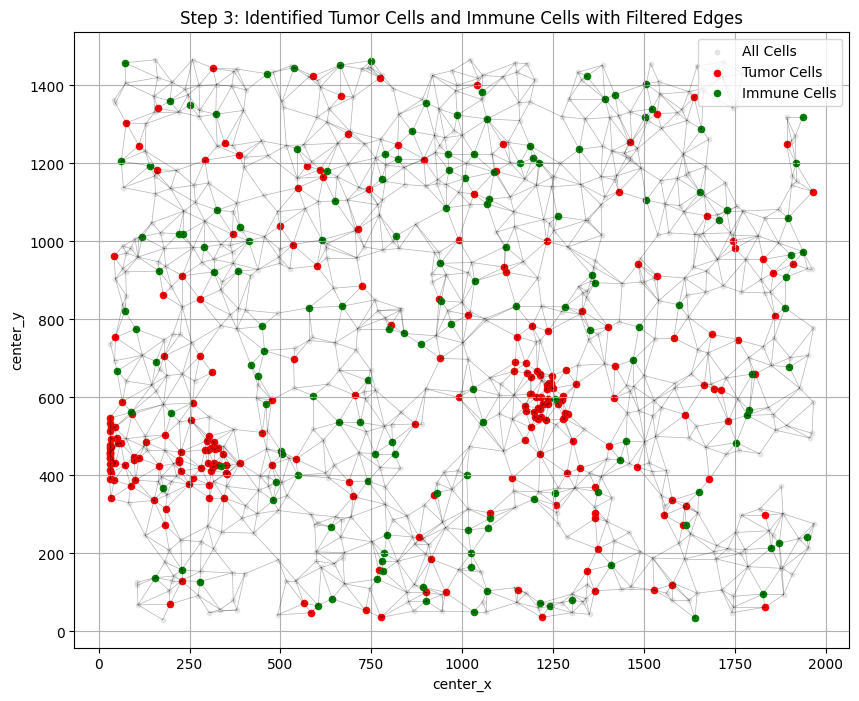

In [15]:
# --- Step 3: Identify Tumor Cells and Immune Cells ---
print("\n--- Identifying Tumor Cells and Immune Cells ---")
df_with_tumor_flag = identify_tumor_cells(df_with_centers.copy(), 'tumor', cell_type_list)
df_with_cell_flags = identify_immune_cells(df_with_tumor_flag.copy(), 'lymphocytes', cell_type_list)
print("DataFrame with Tumor and Immune Flags (first 5 rows):")
display(df_with_cell_flags.head())

# Plot after identifying tumor cells and immune cells
plt.figure(figsize=(10, 8))
plt.scatter(df_with_cell_flags['center_x'], df_with_cell_flags['center_y'], c='lightgray', s=10, alpha=0.5, label='All Cells')
plt.scatter(df_with_cell_flags[df_with_cell_flags['is_tumor']]['center_x'], df_with_cell_flags[df_with_cell_flags['is_tumor']]['center_y'], c='red', s=20, label='Tumor Cells')
plt.scatter(df_with_cell_flags[df_with_cell_flags['is_immune']]['center_x'], df_with_cell_flags[df_with_cell_flags['is_immune']]['center_y'], c='green', s=20, label='Immune Cells')

# Plot the filtered edges
points = df_with_cell_flags[['center_x', 'center_y']].values
for index, row in filtered_edges_df.iterrows():
    i = int(row['source'])
    j = int(row['target'])
    point1 = points[i]
    point2 = points[j]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.5, alpha=0.3) # Using a lighter alpha for edges

plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title('Step 3: Identified Tumor Cells and Immune Cells with Filtered Edges')
plt.grid(True)
plt.legend()
plt.show()

### Step 4: K-hop Neighbors Analysis

This step performs a **k-hop neighbors analysis** for each cell in the dataset. It uses the filtered edges from the Delaunay triangulation (Step 2) to define the connections between cells and the `k_hop_neighbors` function to find all cells reachable within a specified number of hops (`k`).

*   **Using Filtered Edges:** The analysis is based on the graph represented by the `filtered_edges_df`, ensuring that only connections below a certain length are considered.
*   **K-hop Definition:** A k-hop neighbor of a cell is any other cell that can be reached by traversing at most `k` edges from the starting cell in the graph.
*   **`k_hop_neighbors` Function:** The `k_hop_neighbors` function takes the DataFrame, the `filtered_edges_df`, and the value of `k` as input. It utilizes a Breadth-First Search (BFS) algorithm internally to efficiently find all reachable neighbors within `k` hops for each cell.
*   **Output:** The function returns a list of lists, where each inner list contains the indices of the k-hop neighbors for the cell corresponding to that position in the outer list.

This step provides crucial information about the local spatial context of each cell within the filtered graph, which is then used in subsequent analysis steps like the cell function enrichment analysis.

In [16]:
# --- Step 4: K-hop Neighbors Analysis ---
k_value = 2
print(f"\n--- Performing K-hop Neighbors Analysis (k={k_value}) ---")
k_neighbors_results = k_hop_neighbors(df_with_cell_flags.copy(), filtered_edges_df, k_value)
print(f"K-hop Neighbors for the first 5 cells:")
for i in range(min(5, len(k_neighbors_results))):
    print(f"Cell {i}: {k_neighbors_results[i]}")


--- Performing K-hop Neighbors Analysis (k=2) ---
K-hop Neighbors for the first 5 cells:
Cell 0: [0, 1, 3, 4, 6, 10, 14, 15, 16, 19, 20, 21, 24, 27, 36, 220, 586, 658]
Cell 1: [0, 1, 2, 5, 6, 7, 9, 10, 14, 15, 18, 19, 20, 21, 30, 33, 34, 36, 37, 380, 586, 658, 941]
Cell 2: [1, 2, 5, 6, 7, 8, 9, 14, 18, 20, 21, 26, 30, 33, 34, 37, 380, 658, 941]
Cell 3: [0, 3, 4, 6, 10, 11, 16, 17, 19, 21, 23, 24, 25, 27, 211, 220, 349, 429, 586, 626]
Cell 4: [0, 3, 4, 6, 10, 16, 17, 19, 21, 23, 24, 27, 220, 429, 586, 658]


### Step 5: Cell Function Enrichment Analysis (Identify Tumor Regions)

This step performs a **cell function enrichment analysis** to identify regions within the tissue that are enriched for tumor cells. It uses the k-hop neighbor information calculated in the previous step.

*   **Criteria for Enrichment:** The analysis identifies cells based on two criteria applied to their k-hop neighborhood:
    *   **Minimum number of neighbors (N):** The k-hop neighborhood must contain at least `N` cells. This helps to focus on areas with sufficient cell density.
    *   **Minimum ratio of tumor cells (R):** At least `R` proportion of the cells within the k-hop neighborhood must be tumor cells (identified in Step 3). This identifies regions where tumor cells are prevalent.
*   **Identifying Enriched Cells:** The `cell_function_enrichment_analysis` function takes the k-hop neighbor lists and the DataFrame (with the `is_tumor` flag) as input, along with the values for `N` and `R`. It iterates through each cell's neighborhood, checks if both criteria are met, and if so, identifies that cell as belonging to a "tumor region".
*   **Visualization:** The plot shows all cells in light gray, with the cells identified as belonging to a tumor region highlighted (in purple). The filtered edges are also shown for context.

This step allows for the spatial identification of areas that meet specific criteria related to cell density and tumor cell composition, which are considered "tumor regions" for further analysis.


--- Identifying Tumor Regions (N=10, R=0.5) ---
Number of Cells Meeting Enrichment Criteria: 132


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


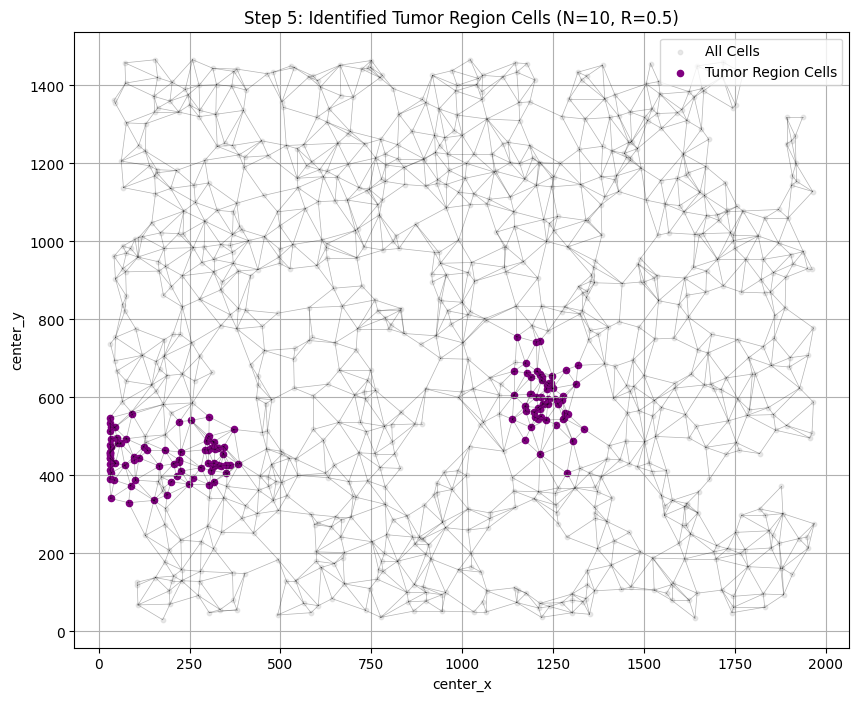

In [17]:
# --- Step 5: Cell Function Enrichment Analysis (Identify Tumor Regions) ---
N_value = 10
R_value = 0.5
print(f"\n--- Identifying Tumor Regions (N={N_value}, R={R_value}) ---")
df_with_regions = cell_function_enrichment_analysis(k_neighbors_results, df_with_cell_flags.copy(), N_value, R_value)
# The cell_function_enrichment_analysis function now returns the DataFrame with 'is_tumor_region'
# enriched_cells = df_with_regions[df_with_regions['is_tumor_region']].index.tolist() # This line is no longer needed as df_with_regions has the column

print(f"Number of Cells Meeting Enrichment Criteria: {df_with_regions['is_tumor_region'].sum()}")

# Plot after identifying tumor regions
plt.figure(figsize=(10, 8))
plt.scatter(df_with_regions['center_x'], df_with_regions['center_y'], c='lightgray', s=10, alpha=0.5, label='All Cells')
# Use the df_with_regions DataFrame directly and filter for 'is_tumor_region'
plt.scatter(df_with_regions[df_with_regions['is_tumor_region']]['center_x'], df_with_regions[df_with_regions['is_tumor_region']]['center_y'], c='purple', s=20, label='Tumor Region Cells')

# Plot the filtered edges
points = df_with_regions[['center_x', 'center_y']].values
for index, row in filtered_edges_df.iterrows():
    i = int(row['source'])
    j = int(row['target'])
    point1 = points[i]
    point2 = points[j]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.5, alpha=0.3) # Using a lighter alpha for edges

plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title(f'Step 5: Identified Tumor Region Cells (N={N_value}, R={R_value})')
plt.grid(True)
plt.legend()
plt.show()

### Step 6: Identify Tumor Region Cells and Border Cells

This step builds upon the identification of tumor regions from Step 5. It first explicitly marks cells that belong to the identified tumor regions and then identifies the cells located at the border of these regions.

*   **Mark Tumor Region Cells:** A new boolean column `is_tumor_region` is added to the DataFrame. This column is set to `True` for all cell indices that were identified as being part of a tumor region in the `cell_function_enrichment_analysis` (Step 5), and `False` otherwise.
*   **Identify Tumor Border Cells:** The `identify_tumor_border_cells` function is used to find the tumor border cells. This function takes the DataFrame (now with the `is_tumor_region` column) and the adjacency list (created from the filtered edges) as input. It identifies tumor region cells that are directly connected to at least one cell *outside* of a tumor region. These cells are marked with `True` in a new boolean column called `is_tumor_border`.

This step is crucial for subsequent analyses that focus on the tumor microenvironment, particularly the interaction zone at the tumor boundary.


--- Identifying Tumor Region and Border Cells ---
DataFrame with Tumor Region and Border Flags (first 5 tumor region cells):


,minx,miny,width,height,prob_epithelial,prob_fibroblast,prob_other,prob_lymphocytes,prob_tumor,prob_macrophages,center_x,center_y,is_tumor,is_immune,is_tumor_region,is_tumor_border
0,1203.963221,600.756497,61,61,0.025935,0.010666,0.052516,0.035194,0.833802,0.041887,1234,631,True,False,True,False
1,1173.255893,570.612375,61,61,0.030700,0.007159,0.056043,0.051074,0.847728,0.007297,1204,601,True,False,True,False
2,1178.322404,543.938169,61,61,0.017346,0.023659,0.046936,0.034197,0.839359,0.038502,1209,574,True,False,True,False
3,1255.250506,640.067661,61,61,0.020555,0.020690,0.027546,0.064762,0.803156,0.063292,1286,671,True,False,True,False
4,1213.242165,606.902679,61,61,0.023954,0.003069,0.034819,0.042839,0.867435,0.027884,1244,637,True,False,True,False


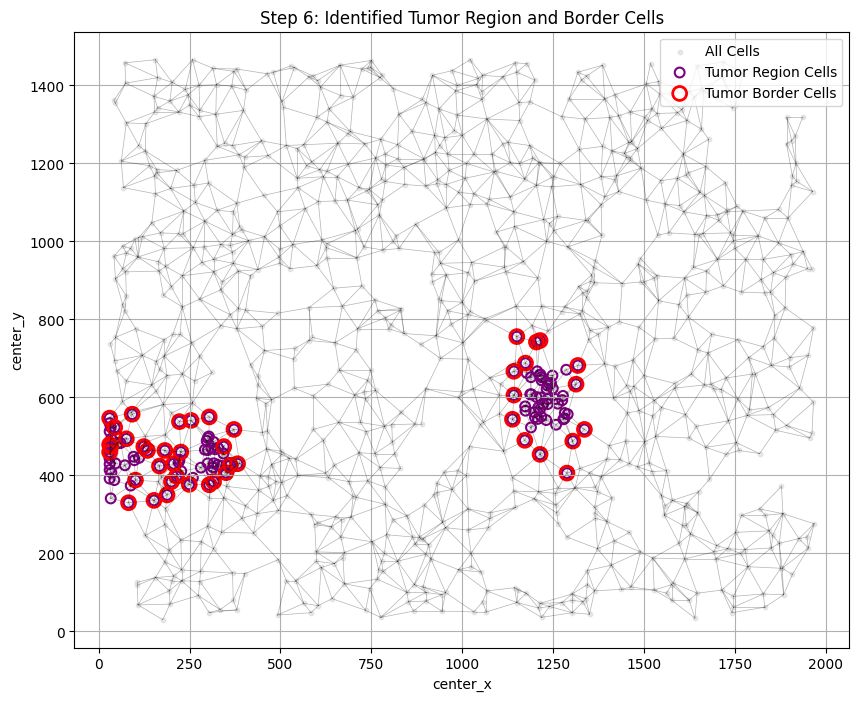

In [18]:
# --- Step 6: Identify Tumor Region Cells and Border Cells ---
print("\n--- Identifying Tumor Region and Border Cells ---")

# Ensure df_with_regions has the 'is_tumor_region' column for this step
# This logic is added here to make this cell runnable independently after Step 5
# In the consolidated cell (Step 9.c), df_with_regions is the direct output of cell_function_enrichment_analysis
# which already includes 'is_tumor_region'.
df_with_regions = cell_function_enrichment_analysis(k_neighbors_results, df_with_cell_flags.copy(), N_value, R_value)

adjacency_list = create_adjacency_list(filtered_edges_df) # Create adjacency list for border identification
df_with_borders = identify_tumor_border_cells(df_with_regions.copy(), adjacency_list)
print("DataFrame with Tumor Region and Border Flags (first 5 tumor region cells):")
display(df_with_borders[df_with_borders['is_tumor_region']].head())

# Plot after identifying tumor border cells
plt.figure(figsize=(10, 8))
plt.scatter(df_with_borders['center_x'], df_with_borders['center_y'], c='lightgray', s=10, alpha=0.5, label='All Cells')
plt.scatter(df_with_borders[df_with_borders['is_tumor_region']]['center_x'], df_with_borders[df_with_borders['is_tumor_region']]['center_y'], facecolors='none', edgecolors='purple', s=50, label='Tumor Region Cells', linewidth=1.5)
plt.scatter(df_with_borders[df_with_borders['is_tumor_border']]['center_x'], df_with_borders[df_with_borders['is_tumor_border']]['center_y'], facecolors='none', edgecolors='red', s=100, label='Tumor Border Cells', linewidth=2)

# Plot the filtered edges
points = df_with_borders[['center_x', 'center_y']].values
for index, row in filtered_edges_df.iterrows():
    i = int(row['source'])
    j = int(row['target'])
    point1 = points[i]
    point2 = points[j]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.5, alpha=0.3) # Using a lighter alpha for edges

plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title('Step 6: Identified Tumor Region and Border Cells')
plt.grid(True)
plt.legend()
plt.show()

### Step 7: Calculate Distance to Border and Assign Signed Distance

This step calculates the shortest distance (in terms of edge hops) from every cell in the dataset to the nearest identified tumor border cell. It then assigns a **signed distance** to each cell, indicating not only the distance but also whether the cell is located inside or outside the tumor region.

*   **Calculate Distance to Border:** The `calculate_distance_to_border` function uses a Breadth-First Search (BFS) algorithm starting from all identified tumor border cells. The distance for each cell is the minimum number of edge hops required to reach a tumor border cell.
*   **Assign Signed Distance:** A new column `signed_distance_to_border` is created. Cells within a tumor region (`is_tumor_region` is True) are assigned a negative distance, while cells outside the tumor region are assigned a positive distance. The magnitude of the distance is the number of edge hops calculated in the previous sub-step. Tumor border cells (distance 0) can be represented as having a signed distance of 0.
*   **Handle Infinite Distances:** Cells that are not connected to the main graph containing the tumor border might have an infinite distance. These are typically handled (e.g., replaced with NaN) for visualization purposes.

This signed distance metric provides a valuable spatial context for each cell relative to the tumor boundary, allowing for analysis of how cell characteristics or interactions vary with distance from the border.


--- Calculating Signed Distance to Tumor Border ---
DataFrame with Signed Distance to Border (first 5 rows):


,is_tumor_region,is_tumor_border,distance_to_border,signed_distance_to_border
0,True,False,2.0,-2.0
1,True,False,2.0,-2.0
2,True,False,2.0,-2.0
3,True,False,1.0,-1.0
4,True,False,2.0,-2.0


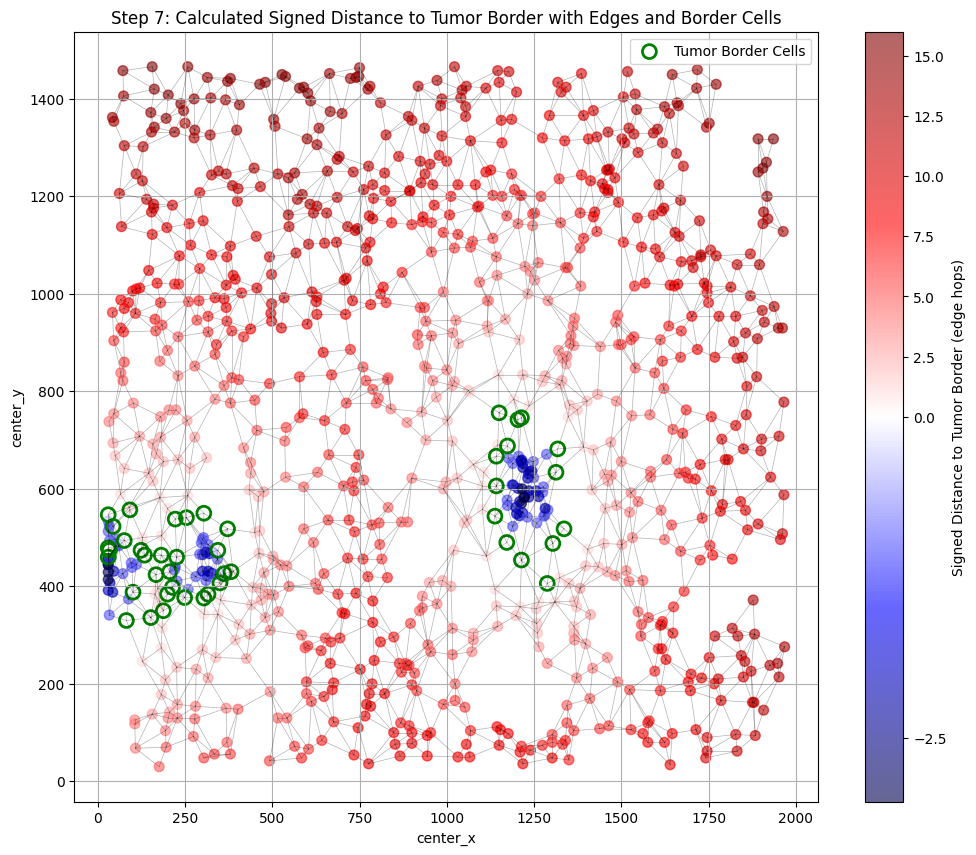

In [19]:
# --- Step 7: Calculate Distance to Border and Assign Signed Distance ---
print("\n--- Calculating Signed Distance to Tumor Border ---")
df_with_distances = calculate_distance_to_border(df_with_borders.copy(), adjacency_list)
df_with_distances['signed_distance_to_border'] = df_with_distances['distance_to_border']
df_with_distances.loc[df_with_distances['is_tumor_region'], 'signed_distance_to_border'] *= -1

# Handle infinite distances for visualization by replacing with NaN
df_with_distances['signed_distance_to_border'] = df_with_distances['signed_distance_to_border'].replace([np.inf, -np.inf], np.nan)


print("DataFrame with Signed Distance to Border (first 5 rows):")
display(df_with_distances[['is_tumor_region', 'is_tumor_border', 'distance_to_border', 'signed_distance_to_border']].head())

# Plot after calculating signed distance
plt.figure(figsize=(12, 10))

# Plot the filtered edges first to be underneath the cells
points = df_with_distances[['center_x', 'center_y']].values
for index, row in filtered_edges_df.iterrows():
    i = int(row['source'])
    j = int(row['target'])
    point1 = points[i]
    point2 = points[j]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.5, alpha=0.3) # Using a lighter alpha for edges


norm = TwoSlopeNorm(vmin=df_with_distances['signed_distance_to_border'].min(),
                    vcenter=0, vmax=df_with_distances['signed_distance_to_border'].max())
scatter = plt.scatter(df_with_distances['center_x'], df_with_distances['center_y'],
                      c=df_with_distances['signed_distance_to_border'], cmap='seismic', s=50, alpha=0.6, norm=norm)
plt.colorbar(scatter, label='Signed Distance to Tumor Border (edge hops)')


# Plot tumor border cells with a red circle outline on top
plt.scatter(df_with_distances[df_with_distances['is_tumor_border']]['center_x'], df_with_distances[df_with_distances['is_tumor_border']]['center_y'],
            facecolors='none', edgecolors='green', s=100, label='Tumor Border Cells', linewidth=2)


plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title('Step 7: Calculated Signed Distance to Tumor Border with Edges and Border Cells')
plt.grid(True)
plt.legend() # Add legend to show Tumor Border Cells
plt.show()

### Step 8: Visualize Signed Distance Layers

This step generates the final comprehensive plot of the analysis. It visualizes the spatial distribution of all cells, colored based on their calculated **signed distance to the tumor border**.

*   **Cells are colored by Signed Distance:** The primary visual element is a scatter plot where each cell is represented by a point, and its color corresponds to the value in the `signed_distance_to_border` column. A diverging colormap ('seismic' is used here) is applied, typically with a neutral color (like white) centered at a signed distance of 0 (the tumor border), and different colors (e.g., blue for negative distances, red for positive distances) representing distances inside and outside the tumor region, respectively.
*   **Tumor Border Cells Highlighted:** Cells identified as being on the tumor border (`is_tumor_border` is True) are highlighted with a red circle outline. This visually confirms the location of the border relative to the signed distance coloring.
*   **Immune Cell Highlighted:** Cells identified as immune cells (`is_immune` is True) are highlighted with a green circle outline. This allows for visual assessment of the spatial distribution of immune cells relative to the tumor border and other cells.
*   **Filtered Edges Displayed:** The filtered Delaunay edges are plotted as thin gray lines underneath the cells. This provides context by showing the underlying graph structure used for the distance calculations.
*   **Colorbar:** A colorbar is included to provide a legend for the signed distance values and their corresponding colors on the colormap.

This plot provides a complete spatial overview, showing the cells' locations, the identified tumor regions, the tumor border, the network of connections between cells, and the signed distance of each cell to the border, with specific cell types (tumor border cells and immune cells) highlighted.


--- Visualizing Signed Distance Layers (Final Plot) ---


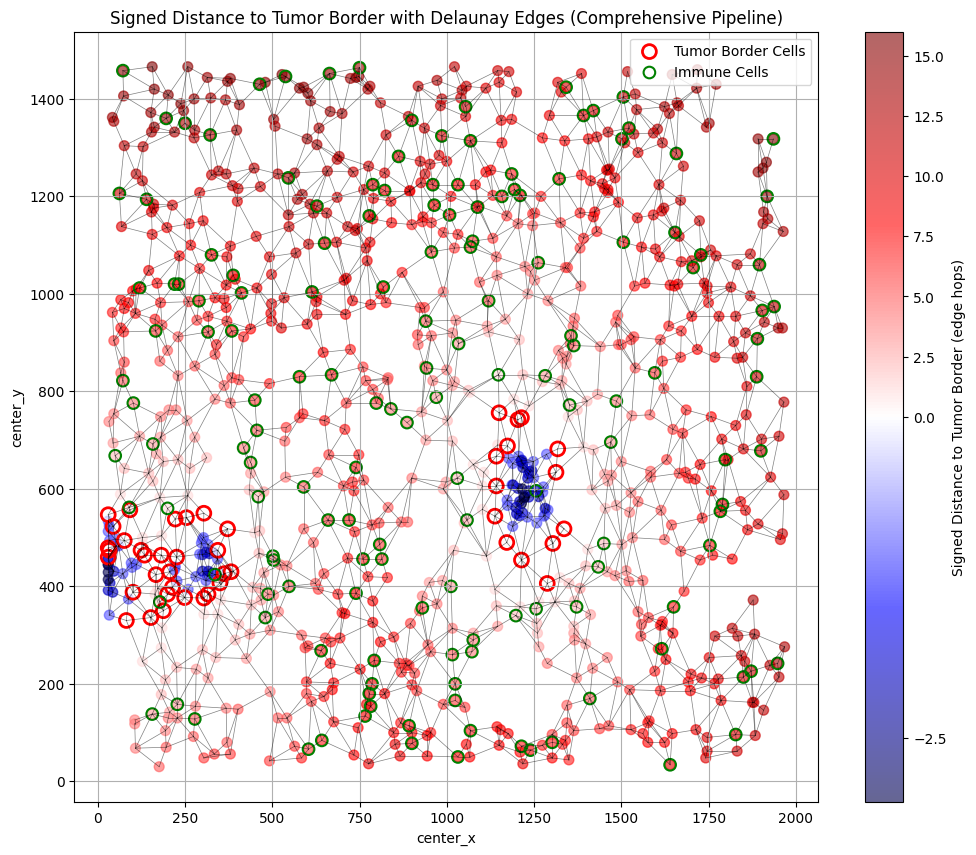

In [20]:
# --- Step 8: Visualize Signed Distance Layers ---
print("\n--- Visualizing Signed Distance Layers (Final Plot) ---")
plt.figure(figsize=(12, 10))

# Scatter plot colored by signed distance to border
# Use TwoSlopeNorm to ensure white is exactly at the center (0)
norm = TwoSlopeNorm(vmin=df_with_distances['signed_distance_to_border'].min(),
                    vcenter=0, vmax=df_with_distances['signed_distance_to_border'].max())
scatter = plt.scatter(df_with_distances['center_x'], df_with_distances['center_y'],
                      c=df_with_distances['signed_distance_to_border'], cmap='seismic', s=50, alpha=0.6, norm=norm)

plt.colorbar(scatter, label='Signed Distance to Tumor Border (edge hops)')

# Highlight tumor border cells
plt.scatter(df_with_distances[df_with_distances['is_tumor_border']]['center_x'],
            df_with_distances[df_with_distances['is_tumor_border']]['center_y'],
            facecolors='none', edgecolors='red', s=100, label='Tumor Border Cells', linewidth=2)

# Highlight immune cells with green circles
plt.scatter(df_with_distances[df_with_distances['is_immune']]['center_x'],
            df_with_distances[df_with_distances['is_immune']]['center_y'],
            facecolors='none', edgecolors='green', s=70, label='Immune Cells', linewidth=1.5)


# Plot filtered edges
points = df_with_distances[['center_x', 'center_y']].values
for index, row in filtered_edges_df.iterrows():
    i = int(row['source'])
    j = int(row['target'])
    point1 = points[i]
    point2 = points[j]
    plt.plot([point1[0], point2[0]], [point1[1], point2[1]], 'k-', linewidth=0.5, alpha=0.5)


plt.xlabel('center_x')
plt.ylabel('center_y')
plt.title('Signed Distance to Tumor Border with Delaunay Edges (Comprehensive Pipeline)')
plt.grid(True)
plt.legend()
plt.show()

### Step 9: Visualize Immune Cell Ratio by Signed Distance

This step analyzes and visualizes the relationship between the spatial location of cells relative to the tumor border and the presence of immune cells. It specifically calculates the **ratio of immune cells** at each unique signed distance value from the tumor border and plots this ratio as a line graph.

*   **Grouping by Signed Distance:** The data is grouped by the `signed_distance_to_border` values calculated in the previous step.
*   **Calculating Immune Cell Ratio:** For each group (each unique signed distance), the ratio of immune cells is calculated by dividing the number of cells identified as immune cells (`is_immune` is True) by the total number of cells at that distance.
*   **Line Plot Visualization:** A line plot is generated with the signed distance on the x-axis and the corresponding immune cell ratio on the y-axis. This plot helps to visually assess whether immune cells tend to be more or less prevalent at certain distances from the tumor border.

This visualization can provide insights into the spatial distribution of immune cells in relation to the tumor microenvironment, particularly the tumor border.


--- Visualizing Immune Cell Ratio by Signed Distance ---


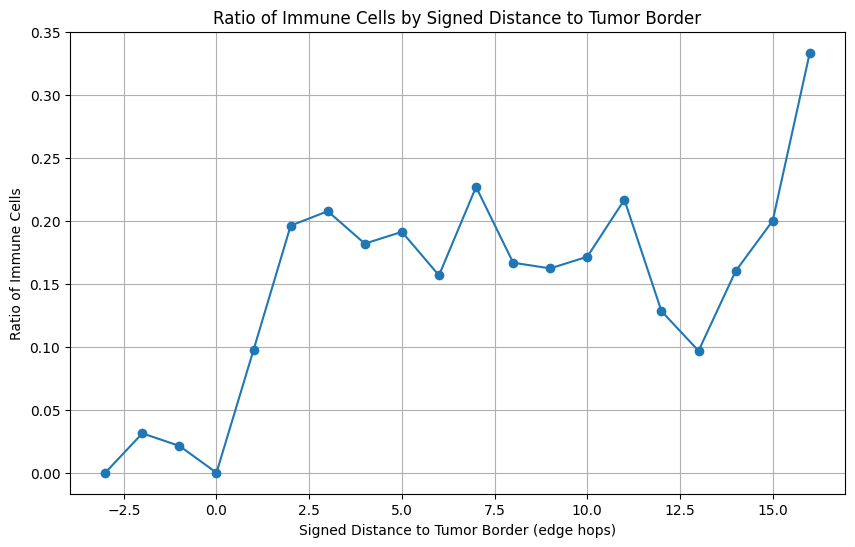

In [21]:
# --- Step 9.a: Visualize Immune Cell Ratio by Signed Distance ---
print("\n--- Visualizing Immune Cell Ratio by Signed Distance ---")
# Group by signed_distance_to_border and calculate the ratio of immune cells
# Handle potential empty groups or no immune cells at a distance
# Exclude NaN distances from grouping
immune_ratio_by_distance = df_with_distances.dropna(subset=['signed_distance_to_border']).groupby('signed_distance_to_border')['is_immune'].apply(lambda x: x.sum() / len(x) if len(x) > 0 else 0)


# Sort by distance for a clear line plot
immune_ratio_by_distance = immune_ratio_by_distance.sort_index()

# Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(immune_ratio_by_distance.index, immune_ratio_by_distance.values, marker='o', linestyle='-')

plt.xlabel('Signed Distance to Tumor Border (edge hops)')
plt.ylabel('Ratio of Immune Cells')
plt.title('Ratio of Immune Cells by Signed Distance to Tumor Border')
plt.grid(True)
plt.show()


--- Visualizing Immune Cell Ratio by Cumulative Average Distance ---


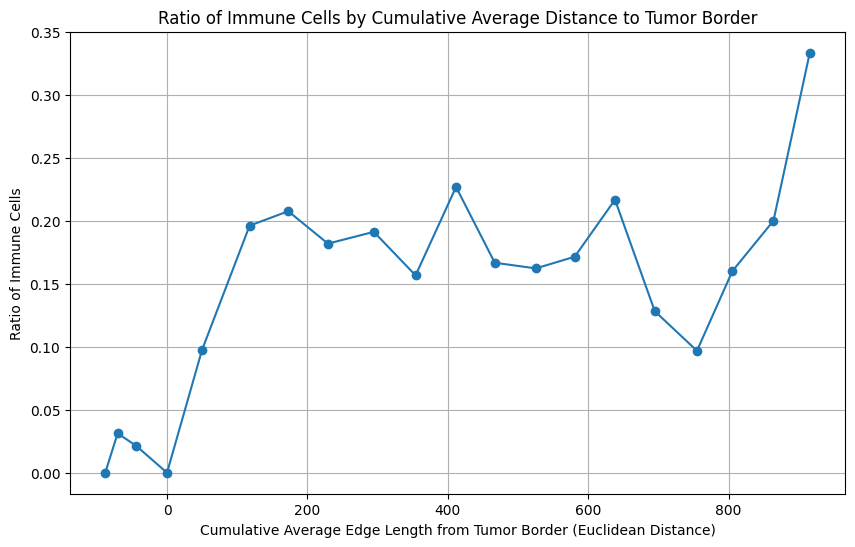

In [22]:
# --- Step 9.b: Visualize Immune Cell Ratio by Cumulative Average Distance ---
print("\n--- Visualizing Immune Cell Ratio by Cumulative Average Distance ---")

# Call the function and get the data for plotting
immune_ratio_plot_data = calculate_cumulative_avg_distance_immune_cell_ratio(df_with_distances, filtered_edges_df)

# Step 6: Create the line plot
plt.figure(figsize=(10, 6))
plt.plot(immune_ratio_plot_data['cumulative_avg_edge_length'], immune_ratio_plot_data['immune_ratio'], marker='o', linestyle='-')

plt.xlabel('Cumulative Average Edge Length from Tumor Border (Euclidean Distance)')
plt.ylabel('Ratio of Immune Cells')
plt.title('Ratio of Immune Cells by Cumulative Average Distance to Tumor Border')
plt.grid(True)
plt.show()

In [23]:
num_cells = 1000
image_width = 2000
image_height = 1500
patch_width = 61
patch_height = 61
cell_type_list = ['epithelial','fibroblast','other','lymphocytes','tumor','macrophages']
num_clusters = 3
cluster_deviation = 50
max_edge_length = 100
k_value = 2
N_value = 10
R_value = 0.5

result_df = pd.DataFrame({'region_id':[], 'layer':[], 'value':[], 'group':[], 'distance':[]})

for i in range(50):
  region_id = f"Region_{i}"
  label = 'odd' if i % 2 == 0 else 'eve'

  # Simulate data
  simulated_df = simulate_model_outputs(num_cells, image_width, image_height, patch_width, patch_height, cell_type_list, num_clusters, cluster_deviation)

  # Delaunay Triangulation and Edge Filtering (modifies simulated_df in place to add center_x/y)
  filtered_edges_df, df_with_centers = delaunay_triangulation(simulated_df, max_edge_length) # delaunay_triangulation returns the modified df

  # Identify Tumor Cells and Immune Cells (modifies df_with_centers in place)
  df_with_cell_flags = identify_tumor_cells(df_with_centers, 'tumor', cell_type_list) # identify_tumor_cells returns the modified df
  df_with_cell_flags = identify_immune_cells(df_with_cell_flags, 'lymphocytes', cell_type_list) # identify_immune_cells returns the modified df

  # K-hop Neighbors Analysis
  k_neighbors_results = k_hop_neighbors(df_with_cell_flags, filtered_edges_df, k_value)

  # Cell Function Enrichment Analysis (Identify Tumor Regions)
  df_with_regions = cell_function_enrichment_analysis(k_neighbors_results, df_with_cell_flags, N_value, R_value)

  # Identify Tumor Region Cells and Border Cells (modifies df_with_cell_flags in place)
  adjacency_list = create_adjacency_list(filtered_edges_df) # Create adjacency list for border identification
  df_with_borders = identify_tumor_border_cells(df_with_regions, adjacency_list) # identify_tumor_border_cells returns the modified df

  # Calculate Distance to Border and Assign Signed Distance (modifies df_with_borders in place)
  df_with_distances = calculate_distance_to_border(df_with_borders, adjacency_list) # calculate_distance_to_border returns the modified df
  df_with_distances['signed_distance_to_border'] = df_with_distances['distance_to_border']
  df_with_distances.loc[df_with_distances['is_tumor_region'], 'signed_distance_to_border'] *= -1
  df_with_distances['signed_distance_to_border'] = df_with_distances['signed_distance_to_border'].replace([np.inf, -np.inf], np.nan)

  # Prepare data for immune cell ratio by signed distance plot
  immune_ratio_plot_data = calculate_cumulative_avg_distance_immune_cell_ratio(df_with_distances, filtered_edges_df)

  for layer in range(-12, 24):
    if layer in immune_ratio_plot_data['signed_distance'].tolist():
      value = immune_ratio_plot_data[immune_ratio_plot_data['signed_distance'] == layer]['immune_ratio'].values[0]
      distance = immune_ratio_plot_data[immune_ratio_plot_data['signed_distance'] == layer]['cumulative_avg_edge_length'].values[0]
      result_df.loc[len(result_df)] = [region_id, layer, value, label, distance]


<Axes: title={'center': 'Spatial Heterogeneity Profile (H-Plot)'}, xlabel='Distance to tumor boundary\nCellular layers / Euclidean distance (um)', ylabel='Proportion of lymphocytes'>

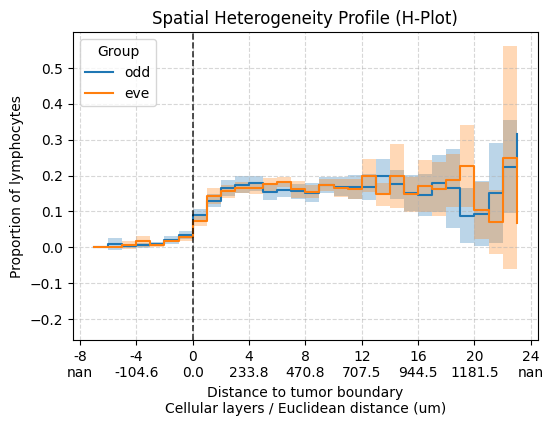

In [25]:
h = HPlot()
h.fit(result_df, value_col='value', layer_col='layer', group_col='group', distance_col='distance', distance_unit='um')
h.plot(ci_show=True)